In [1]:
import numpy as np
import torch

from torch.nn import Linear
from torch.utils.data import DataLoader, TensorDataset

from functools import partial
from matplotlib import pyplot as plt

from lafomo.datasets import ToyTimeSeries, ToySpatialTranscriptomics
from lafomo.models import NeuralOperator

(1765050, 4)


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


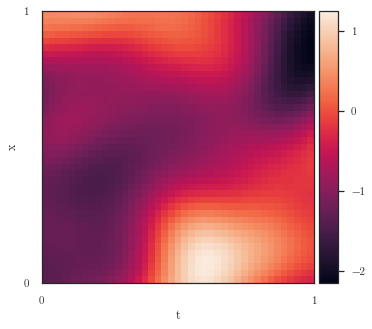

In [2]:
from lafomo.utilities.torch import get_image
from lafomo.plot import Plotter, plot_spatiotemporal_data

dataset = ToySpatialTranscriptomics('../../data', one_fixed_sample=False)

i = 49
orig_data = dataset.orig_data[1681*(i):1681*(i+1)]
images = [get_image(orig_data, i) for i in range(2, 4)]
tx = dataset.data[0][0]
num_t = tx[0, :].unique().shape[0]
num_x = tx[1, :].unique().shape[0]

ts = tx[0, :].unique().sort()[0].numpy()
xs = tx[1, :].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [torch.tensor(orig_data[:, 2]).view(num_t, num_x).t()],
    extent, nrows=1, ncols=1
)
block_dim = 2

ntest = 50
ntrain = len(dataset) - ntest
batch_size = 50
learning_rate = 0.001

modes = 12
width = 32
def generate_neural_dataset(dataset, ntrain, ntest):
    s = 41
    tx, _ = dataset.data[0]
    grid = tx.t()
    grid = torch.tensor(grid.reshape(1,s,s,2), dtype=torch.float)

    data = torch.tensor(dataset.orig_data.reshape(len(dataset), s, s, 4), dtype=torch.float)
    y_train = data[:ntrain, ..., 2:3]
    x_train = data[:ntrain, ..., 3]
    y_test = data[ntrain:, ..., 2:3]
    x_test = data[ntrain:, ..., 3]

    x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
    x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

    train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                              batch_size=batch_size, shuffle=True)
    if ntest > 0:
        test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                              batch_size=ntest, shuffle=True)
        return train_loader, test_loader
    else:
        return train_loader

train_loader, test_loader = generate_neural_dataset(dataset, ntrain, ntest)

In [ ]:
num_outputs = 10
basal_rate = 0.1 + 0.3 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
sensitivity = 2 + 5 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)
decay_rate = 0.2 + 2 * torch.rand(torch.Size([num_outputs, 1]), dtype=torch.float32)


In [ ]:
ntrain = 15
ntest = 5
learning_rate = 1e-3
batch_size = ntrain

datasets = list()
for i in range(ntrain + ntest):
    dataset = ToyTimeSeries(num_outputs, 1, 10, params=[basal_rate, sensitivity, decay_rate], plot=False)
    datasets.append(dataset)

In [ ]:
x_train = torch.cat([dataset.m_observed for dataset in datasets[:ntrain]]).permute(0, 2, 1)
x_test = torch.cat([dataset.m_observed for dataset in datasets[ntrain:]]).permute(0, 2, 1)
T_in = 11
grid = datasets[0].t_observed.reshape(1, -1, 1).repeat(ntrain, 1, 1) # (1, 32, 32, 40, 1)
grid_test = datasets[0].t_observed.reshape(1, -1, 1).repeat(ntest, 1, 1) # (1, 32, 32, 40, 1)

x_train = torch.cat([grid, x_train], dim=-1)
x_test = torch.cat([grid_test, x_test], dim=-1)
y_train = torch.cat([dataset.f_observed for dataset in datasets[:ntrain]]).permute(0, 2, 1)
y_test = torch.cat([dataset.f_observed for dataset in datasets[ntrain:]]).permute(0, 2, 1)
print('y', y_train.shape)
print('x', x_train.shape)

train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                          batch_size=ntest, shuffle=True)

In [3]:
width = 20
modes = 4
model = NeuralOperator(block_dim, modes, width)
print(model.count_params())

55777


In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

In [15]:
trainer.train(20);

Epoch 023/042 - Loss: 0.50 (0.25 0.01 0.52)
Epoch 024/042 - Loss: 0.49 (0.24 0.01 0.51)
Epoch 025/042 - Loss: 0.48 (0.22 0.00 0.50)
Epoch 026/042 - Loss: 0.46 (0.21 0.00 0.49)
Epoch 027/042 - Loss: 0.45 (0.20 0.00 0.48)
Epoch 028/042 - Loss: 0.44 (0.19 0.00 0.46)
Epoch 029/042 - Loss: 0.43 (0.18 0.00 0.45)
Epoch 030/042 - Loss: 0.42 (0.17 0.00 0.44)
Epoch 031/042 - Loss: 0.41 (0.16 0.00 0.44)
Epoch 032/042 - Loss: 0.40 (0.15 0.00 0.43)
Epoch 033/042 - Loss: 0.40 (0.15 0.00 0.41)
Epoch 034/042 - Loss: 0.38 (0.14 0.00 0.40)
Epoch 035/042 - Loss: 0.38 (0.14 0.00 0.40)
Epoch 036/042 - Loss: 0.37 (0.13 0.00 0.39)
Epoch 037/042 - Loss: 0.36 (0.13 0.00 0.39)
Epoch 038/042 - Loss: 0.36 (0.12 0.00 0.38)
Epoch 039/042 - Loss: 0.35 (0.12 0.00 0.37)
Epoch 040/042 - Loss: 0.34 (0.11 0.00 0.36)
Epoch 041/042 - Loss: 0.34 (0.11 0.00 0.36)
Epoch 042/042 - Loss: 0.33 (0.11 0.00 0.36)


In [12]:
def show_result(x, y, out):
    if block_dim == 1:
        fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
        for i in range(1, 5):
            axes[0].plot(x[0, :, i])#.shape, y.shape)
        axes[1].plot(y[0, :, 0])
        axes[1].plot(out[0, :, 0].detach())
    else:
        plot_spatiotemporal_data(
            [
                out[0, ..., 0].detach().view(num_t, num_x).t(),
                y[0, ..., 0].view(num_t, num_x).t(),
                x[0, ..., 0].view(num_t, num_x).t()
            ],
            extent, nrows=1, ncols=3,
            titles=['Latent (Prediction)', 'Latent (Target)', 'Output (Target)']
        )

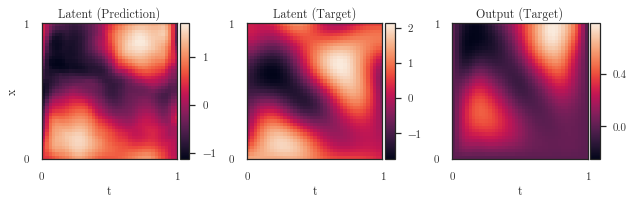

In [14]:
x, y = next(iter(test_loader))
out = model(x)
show_result(x, y, out)

In [ ]:
dataset = ToySpatialTranscriptomics('../../data', one_fixed_sample=True)
train_loader = generate_neural_dataset(dataset, 1, 0)
x, y = next(iter(train_loader))
out = model(x)
show_result(x, y, out)

In [ ]:
path = '../../data/ns_V1e-3_N5000_T50.mat'
from h5py import File

# u shape (50, 64, 64, 5000)
# a shape (64, 64, 5000)
# t shape (50, 1)

f = File(path)
print(f)
print(f['u'])

modes = 4
width = 20

batch_size = 10
batch_size2 = batch_size

epochs = 10
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)


runtime = np.zeros(2, )

ntrain = 100
sub = 1
S = 64 // sub
T_in = 10
T = 40
S = 32

# train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
# train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]
train_a = torch.rand((100, 32, 32, 50))[:, :, :, :T_in]
train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
print(train_a.shape)
# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
# 32
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
# 1, 32, 32, 40, 1 (1, S, S, T, 1)
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])
# (1, S, S, T, 1)
print(gridt.shape, gridx.shape)
# for t in range(10):
#     plt.figure()
#     plt.imshow(gridy.squeeze()[:, :, t])
print(gridx.repeat([ntrain,1,1,1,1]).shape)
train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
print(train_a.shape)

In [ ]:
# This part checks our complex multiplication code:
def compl_mul1d(a, b):
    # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
    op = partial(torch.einsum, "bix,iox->box")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

weights1_sep = torch.rand(20, 20, 4, 2)
weights1_sep = torch.rand(64, 64, 4, 2)
weights1 = weights1_sep[:, :, :, 0] + weights1_sep[:, :, :, 1] * 1j
x = torch.randn((15, 20, 11))
x = torch.randn((100, 64, 1024))
print(x.shape)

In [ ]:
x_ft = torch.fft.rfft(x)
x_ft_sep = torch.stack([
    torch.real(x_ft),
    torch.imag(x_ft)
    ], dim=-1)
print(x_ft_sep.shape)

In [ ]:
mul2 = compl_mul1d(x_ft_sep[:, :, :4], weights1_sep)
print(mul2)

In [ ]:
op = partial(torch.einsum, "bix,iox->box")
    # return torch.stack([
    #     op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
    #     op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    # ], dim=-1)

A = x_ft[:, :, :4]#.unsqueeze(1)
B = weights1#.unsqueeze(0)
print(A.shape, B.shape)
print(A.type())
# print(B.type(torch.complex64))
mul = op(A, B.type(torch.complex64))
# mul = torch.matmul(A, B)
print(mul.shape, mul2.shape)

print(mul2[where])



In [ ]:
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

grid = np.linspace(0, 2*np.pi, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.randn(ntrain, s, 1)
x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)

modes = 16
width = 64
print(x_train.shape)
x = Linear(2, width)(x_train).permute(0, 2, 1)
print(x.shape)